In [1]:
import torch
import numpy as np
from torch.autograd import Variable
from torch.distributions import Normal


class tOU:
    def __init__(self, t0, t1, parameters, sde_sigma, init_dist, timegrid=False, dN=200):
        """
            t0, t1 = torch.tensor(t1)
            alpha, beta, m0, r, sigma = torch.tensor.shape (D, 1)
        """
        assert all(sigma > 0), "variance must be positive"
        
        self.t0 = t0
        self.t1 = t1
        
        # set parameters
        self.alpha = parameters['alpha']
        self.beta = parameters['beta']
        self.r = parameters['r']
        
        # set hyper-parameter
        self.sigma = sde_sigma
        
        D = self.alpha.shape[0]
        if timegrid == True:
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
            
        self.trj, self.dt = self.path(init_dist)
        
            
    def path(self, init_dist):
        """
            init_dist: distribution to draw an initial state
            init_dist = Normal(loc=E[X_{t_{i-1}}|lambda_{i-1}], scale = std[X_{t_{i-1}}|lambda_{i-1}])
        """
        
        # Get parameters

        alpha = self.alpha
        beta = self.beta
        r = self.r
                
        sigma = self.sigma
        
        t = self.pts
        
        
        def mean(x, dt, t0, m0, alpha, beta, r):
            """
                t0: we always start our process from t = 0
            """
            s = t0[:, 0].reshape(-1, 1)
            t = t0[:, 1].reshape(-1, 1)
            
            b_t = alpha * ( (s + 1) ** beta  - 1) + m0 - (alpha  * ((t + 1) ** beta - 1) + m0 ) * torch.exp(r * dt.reshape(-1, 1))
            
            return (x.reshape(-1, 1) - b_t) * torch.exp(-r * dt.reshape(-1, 1))
        
        def variance(t0, r, sigma):
            dt = torch.diff(t0)
            return sigma * sigma * (1 - torch.exp(-2 * r * dt)) / (2*r)
        
        def std(t0, r, sigma):
            return torch.sqrt(variance(t0, r, sigma))

        
        normal = Normal(loc=0., scale=1.)
        x = normal.sample(t.size())

        if type(init_dist) == torch.distributions.normal.Normal:
            # sample initial state from approximate posterior distribution
            m0 = init_dist.sample([x.shape[0], 1])
            x[:, 0] = m0.flatten()
        else:
            m0 = init_dist
            x[:, 0] = m0.flatten()
            
        t0 = t - t[:, 0].reshape(-1, 1)

        dt = torch.diff(t)

        scale = std(t0, r, sigma)
        
        x[:, 1:] = x[:, 1:] * scale
        for i in range(1, x.shape[1]):
            x[:, i] += mean(x[:, i-1], dt[:, i-1], t0[:, i-1:i+1], m0, alpha, beta, r).flatten()
        
        return x, dt

def tou_gradient(pts, x, params, sde_sigma, init_dist):
    assert torch.is_tensor(sde_sigma), "sde_sigma must be a (D*1) tensor"
    assert torch.is_tensor(init_dist) or type(init_dist) == torch.distributions.normal.Normal,\
    "init_dist must either be tensor or torch.distributions"
    
    """
        Calculates log likelihood of a path
        Note that there are three parameters, alpha, beta, r
    """
    
    def mean(x, time, m0, alpha, beta, r):
        """
            t0: we always start our process from t = 0
        """
        t0 = time - time[:, 0].reshape(-1, 1)
        
        dt = torch.diff(t0)
        
        s = t0[:, :-1]
        t = t0[:, 1:]

        b_t = alpha * ( (s + 1) ** beta  - 1) + m0 - (alpha  * ((t + 1) ** beta - 1) + m0 ) * torch.exp(r * dt)

        return (x - b_t) * torch.exp(-r * dt)

    def variance(time, r, sigma):
        dt = torch.diff(time)
        return sigma * sigma * (1 - torch.exp(-2 * r * dt)) / (2*r)
    

    def std(time, r, sigma):
        return torch.sqrt(variance(time, r, sigma))
    
    param_stack = torch.stack([params['alpha'], params['beta'], params['r']])
    
    params_ = Variable(param_stack, requires_grad=True)
    alpha, beta, r = params_
    sigma = sde_sigma

    m0 = x[:, 0].reshape(-1, 1)
    mu = mean(x[:, :-1], pts, m0, alpha, beta, r)

    var = std(pts, r, sigma) + 1e-7 # To prevent the underflow (some of the value becomes 0 due to lack of precision
    LL = torch.nansum(Normal(loc=mu, scale=var).log_prob(x[:, 1:]), axis=1)
    
    # At initialization (in case of random initialization)
    if type(init_dist) == torch.distributions.normal.Normal:
        LL += torch.sum(init_dist.log_prob(x[:,0]))
    
    LL.backward(torch.tensor([1.]).repeat(x.shape[0]))

    return {'alpha':params_.grad[0].clone().detach(), 'beta':params_.grad[1].clone().detach(), 
            'r':params_.grad[2].clone().detach(), 'LL':LL.clone().detach().data}



In [2]:
def E_of_X ( init_pts, pts, parameters ):
    """
        Return mean of the process (which has analytical expression)
    """
    dt = pts - pts[:, 0].reshape(-1, 1)
    alpha = parameters['alpha']
    beta = parameters['beta']
    r = parameters['r']
    
    return alpha * ((dt + 1) ** beta - 1) + init_pts
    

In [3]:
def V_of_X (pts, parameters, sde_sigma):
    """
        Return standard deviation of the process (from its analytical expression)
    """
    dt = pts - pts[:, 0].reshape(-1, 1)

    r = parameters['r']
    
    return torch.sqrt(sde_sigma * sde_sigma * (1 - torch.exp(-2 * r * dt)) / (2*r))

In [4]:
dist = Normal(loc=0, scale=1.)
t0 = torch.tensor(1.)
t1 = torch.tensor(5.)
sigma = torch.tensor([1.]).reshape(-1, 1)

In [5]:
parameters = {'alpha': torch.tensor([2.]).reshape(-1, 1), \
             'beta': torch.tensor([1.5]).reshape(-1, 1), \
             'r': torch.tensor([1.05]).reshape(-1, 1) }

In [6]:
init_pts = torch.tensor([1.0]).reshape(-1, 1)

In [7]:
tou = tOU(t0, t1, parameters, sigma, init_dist=init_pts)
EX = E_of_X(init_pts, tou.pts, parameters)
VX = V_of_X(tou.pts, parameters, sigma)

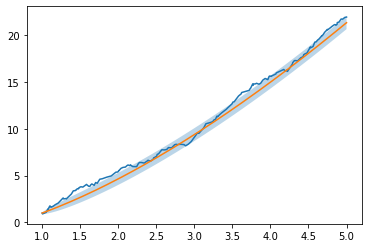

In [8]:
import matplotlib.pylab as plt

plt.plot(tou.pts.T, tou.trj.T)
plt.plot(tou.pts.T, EX.T)
plt.fill_between(tou.pts.flatten(), (EX - VX).flatten(), (EX + VX).flatten(), alpha=0.3)

In [9]:
def Grad_Descent( current_pars, current_grad, params, learning_rate = 0.01):
    """
        Perform vanila gradient descent step
        returns dictionary such that dict["name_of_parameter"] = value after one gradient step
    """
    assert type(current_pars) == type(current_grad) == dict, "Current_grad must be a dict"
    
    new_pars = current_pars.copy()
    for key in current_pars.keys():
        if key == 'r':
            new_pars[key] = current_pars[key] + learning_rate * current_grad[key]
            value = new_pars[key]
            while value <= 0:
                value = current_pars[key] + learning_rate  * current_grad[key]
                learning_rate *= 0.05
            
            new_pars[key] = value
            
        if key in params:
            new_pars[key] = current_pars[key] + learning_rate * current_grad[key]

    return new_pars

In [47]:
def MLE(pts, trj, sigma, dist, init_pars, params, IT, learning_rate, FIX_PARS=False):
    current_pars = init_pars
    pars_hist = {key:[] for key in current_pars.keys()}
    ll_hist = []
    
    for i in range(IT):
        for key in current_pars.keys(): 
            pars_hist[key].append(current_pars[key].item())
        current_grad = tou_gradient(pts, trj, current_pars, sigma, dist)
        
        ll_hist.append(current_grad['LL'].item())
        
        current_pars = Grad_Descent( current_pars, current_grad, params, learning_rate)
        
        if FIX_PARS == True:
            for key in current_pars.keys():
                if key in FIX_PARS.keys():
                    current_pars[key] = FIX_PARS[key]
        
        if i % 50 == 0:
            print("LogLikelihood: {}".format(current_grad['LL']))
            for key in current_pars.keys():
                print(key + ": " + str(current_pars[key].item()))
#         print(current_pars.items())
    return current_pars, pars_hist, ll_hist

**Obtain MLE of alpha and beta given a, b, c**

In [13]:
paras_names = ['alpha', 'beta']
init_pars = {key:torch.tensor([0.01]).reshape(-1, 1) for key in paras_names}

In [14]:
for key in ['r']:
    init_pars[key] = parameters[key]

In [15]:
FIX_PARS = {'r':parameters['r']}

In [25]:
param_mle, param_hist, ll_hist = MLE(tou.pts, tou.trj, sigma, dist, init_pars, paras_names, FIX_PARS, 1000, learning_rate=0.0001)

LogLikelihood: tensor([-391.2878])
alpha: 0.010097239166498184
beta: 0.010097960010170937
LogLikelihood: tensor([-391.2715])
alpha: 0.016411056742072105
beta: 0.016462326049804688
LogLikelihood: tensor([-391.2274])
alpha: 0.026789899915456772
beta: 0.026957597583532333
LogLikelihood: tensor([-391.1056])
alpha: 0.0440283827483654
beta: 0.04450254887342453
LogLikelihood: tensor([-390.7527])
alpha: 0.07318573445081711
beta: 0.07451801002025604
LogLikelihood: tensor([-389.6484])
alpha: 0.12415052205324173
beta: 0.12804418802261353
LogLikelihood: tensor([-385.6268])
alpha: 0.21914377808570862
beta: 0.23159293830394745
LogLikelihood: tensor([-364.4995])
alpha: 0.4247508943080902
beta: 0.4742313027381897
LogLikelihood: tensor([76.9157])
alpha: 1.1493191719055176
beta: 1.5936546325683594
LogLikelihood: tensor([168.7236])
alpha: 1.2758208513259888
beta: 1.7846767902374268
LogLikelihood: tensor([168.8699])
alpha: 1.300344705581665
beta: 1.773240089416504
LogLikelihood: tensor([169.0043])
alpha: 

In [26]:
sample_mle = {key: value.repeat(100, 1) for key,value in param_mle.items()}

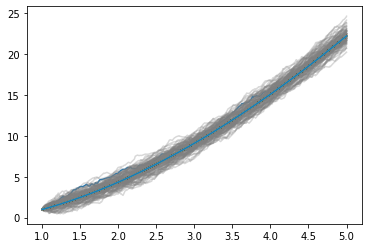

In [27]:
plt.plot(tou.pts.T, tou.trj.T)
tou_mle = tOU(t0 , t1, sample_mle, sigma.repeat(100, 1), init_dist=init_pts)
plt.plot(tou_mle.pts.T.mean(axis=1), tou_mle.trj.T.mean(axis=1), color='black')
plt.plot(tou_mle.pts.T, tou_mle.trj.T, color='grey', alpha=0.3)
plt.plot(tou_mle.pts.T, E_of_X(init_pts, tou_mle.pts, sample_mle).T)

plt.show()

In [28]:
for key in param_mle.keys():
    print(key + "    /  MLE: %.3f" % param_mle[key].item() + "    True: %.3f" % parameters[key].item())

alpha    /  MLE: 1.500    True: 2.000
beta    /  MLE: 1.688    True: 1.500
r    /  MLE: 1.050    True: 1.050


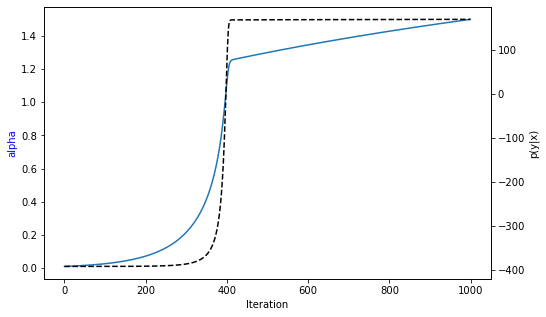

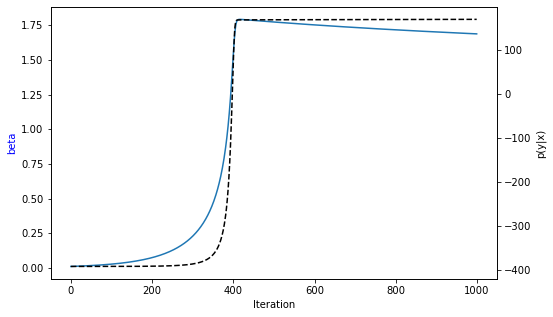

In [34]:
for key in paras_names:
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(np.arange(len(param_hist[key])), param_hist[key], label='parameter')
    ax.set_ylabel(key, color='blue')
    ax1 = ax.twinx()
    ax1.plot(np.arange(len(ll_hist)), ll_hist, color='black', label='log-likelihood', linestyle='dashed')
    
    ax.set_xlabel("Iteration")
    ax1.set_ylabel(r"p(y|x)")

Obtain variance parameter given mean parameters

In [35]:
paras_names = ['r']
init_pars = {key:torch.tensor([3.0]).reshape(-1, 1) for key in paras_names}

In [36]:
fix_pars = ['alpha', 'beta']
for key in fix_pars:
    init_pars[key] = parameters[key]

In [37]:
FIX_PARS = {key:parameters[key] for key in fix_pars}

In [38]:
varP_mle, varP_hist, varLL_hist = MLE(tou.pts, tou.trj, sigma, dist, init_pars, paras_names, FIX_PARS, 1000, learning_rate=0.005)

LogLikelihood: tensor([167.9014])
r: 2.985821485519409
LogLikelihood: tensor([169.3053])
r: 2.400489091873169
LogLikelihood: tensor([169.9506])
r: 2.003567934036255
LogLikelihood: tensor([170.2477])
r: 1.7345657348632812
LogLikelihood: tensor([170.3830])
r: 1.552320122718811
LogLikelihood: tensor([170.4461])
r: 1.4288766384124756
LogLikelihood: tensor([170.4746])
r: 1.3452708721160889
LogLikelihood: tensor([170.4879])
r: 1.2886475324630737
LogLikelihood: tensor([170.4938])
r: 1.2503042221069336
LogLikelihood: tensor([170.4967])
r: 1.224339246749878
LogLikelihood: tensor([170.4987])
r: 1.2067551612854004
LogLikelihood: tensor([170.4988])
r: 1.1948473453521729
LogLikelihood: tensor([170.4991])
r: 1.1867854595184326
LogLikelihood: tensor([170.4992])
r: 1.1813262701034546
LogLikelihood: tensor([170.4992])
r: 1.1776310205459595
LogLikelihood: tensor([170.4992])
r: 1.1751240491867065
LogLikelihood: tensor([170.4989])
r: 1.1734322309494019
LogLikelihood: tensor([170.4995])
r: 1.17228424549102

In [39]:
for key in varP_mle.keys():
    print(key + "    /  MLE: %.3f" % varP_mle[key].item() + "    True: %.3f" % parameters[key].item())

r    /  MLE: 1.171    True: 1.050
alpha    /  MLE: 2.000    True: 2.000
beta    /  MLE: 1.500    True: 1.500


In [40]:
varSam_mle = {key: value.repeat(100, 1) for key,value in varP_mle.items()}

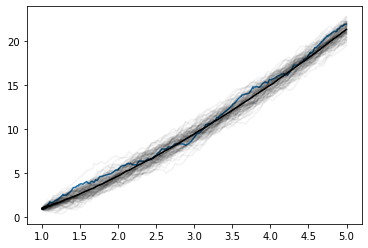

In [41]:
plt.plot(tou.pts.T, tou.trj.T)
tou_Varmle = tOU(t0 , t1, varSam_mle, sigma.repeat(100, 1), init_dist=init_pts)
plt.plot(tou_Varmle.pts.T.mean(axis=1), tou_Varmle.trj.T.mean(axis=1), color='black')
plt.plot(tou_Varmle.pts.T, tou_Varmle.trj.T, color='black', alpha=0.05)
plt.show()

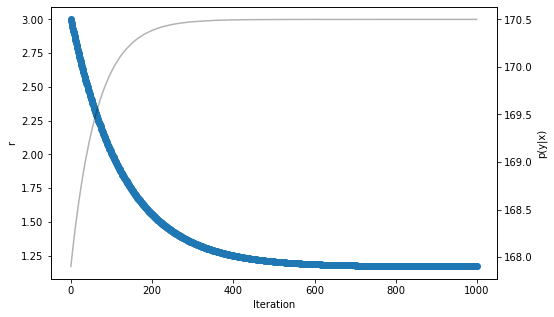

In [42]:
for key in paras_names:
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(np.arange(len(varP_hist[key])), varP_hist[key])
    ax.set_ylabel(key)
    ax1 = ax.twinx()
    ax1.plot(np.arange(len(varLL_hist)), varLL_hist, color='black', alpha=0.3)
    
    ax.set_xlabel("Iteration")
    ax1.set_ylabel(r"p(y|x)")

Obtain MLE for every parameter

In [44]:
paras_names = ['alpha', 'beta', 'r']
init_pars = {key:torch.randn(1).reshape(-1, 1) + 2. for key in paras_names}

In [55]:
mle, pars, ll = MLE(tou.pts, tou.trj, sigma, dist, init_pars, paras_names, 5000, learning_rate=0.0003)

LogLikelihood: tensor([-640.3212])
alpha: 0.29367583990097046
beta: 0.990462064743042
r: 1.1647295951843262
LogLikelihood: tensor([166.7866])
alpha: 0.9896944761276245
beta: 1.7918015718460083
r: 0.000585526111535728
LogLikelihood: tensor([168.3269])
alpha: 1.061147689819336
beta: 1.8493164777755737
r: 0.05406118184328079
LogLikelihood: tensor([168.4267])
alpha: 1.0931291580200195
beta: 1.8344329595565796
r: 0.06553589552640915
LogLikelihood: tensor([168.5126])
alpha: 1.1241340637207031
beta: 1.8204118013381958
r: 0.07766537368297577
LogLikelihood: tensor([168.5973])
alpha: 1.1542364358901978
beta: 1.8071712255477905
r: 0.0903192013502121
LogLikelihood: tensor([168.6722])
alpha: 1.1834970712661743
beta: 1.7946288585662842
r: 0.1035064160823822
LogLikelihood: tensor([168.7483])
alpha: 1.2119663953781128
beta: 1.7827068567276
r: 0.11712952703237534
LogLikelihood: tensor([168.8233])
alpha: 1.2396918535232544
beta: 1.7713435888290405
r: 0.13114915788173676
LogLikelihood: tensor([168.8935])

LogLikelihood: tensor([171.4682])
alpha: 2.270613670349121
beta: 1.4439213275909424
r: 1.3663793802261353
LogLikelihood: tensor([171.4803])
alpha: 2.274740695953369
beta: 1.4428588151931763
r: 1.379236102104187
LogLikelihood: tensor([171.4918])
alpha: 2.2787017822265625
beta: 1.4418400526046753
r: 1.3919451236724854
LogLikelihood: tensor([171.5042])
alpha: 2.2825026512145996
beta: 1.4408636093139648
r: 1.404508113861084
LogLikelihood: tensor([171.5147])
alpha: 2.286149740219116
beta: 1.4399285316467285
r: 1.4169254302978516
LogLikelihood: tensor([171.5256])
alpha: 2.2896435260772705
beta: 1.4390324354171753
r: 1.429198145866394
LogLikelihood: tensor([171.5363])
alpha: 2.2929928302764893
beta: 1.4381746053695679
r: 1.4413273334503174
LogLikelihood: tensor([171.5471])
alpha: 2.2961974143981934
beta: 1.4373551607131958
r: 1.4533138275146484
LogLikelihood: tensor([171.5565])
alpha: 2.299264669418335
beta: 1.4365711212158203
r: 1.4651590585708618
LogLikelihood: tensor([171.5665])
alpha: 2.3

In [56]:
for key in mle.keys():
    print(key + "    /  MLE: %.3f" % mle[key].item() + "    True: %.3f" % parameters[key].item())

alpha    /  MLE: 2.321    True: 2.000
beta    /  MLE: 1.431    True: 1.500
r    /  MLE: 1.565    True: 1.050


In [57]:
sample_mle = {key: value.repeat(100, 1) for key,value in mle.items()}

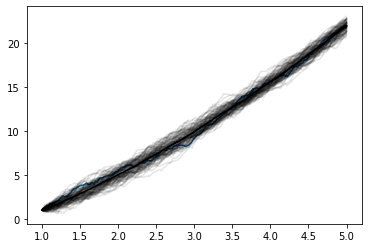

In [58]:
plt.plot(tou.pts.T, tou.trj.T)
tou_mle = tOU(t0 , t1, sample_mle, sigma.repeat(100, 1), init_dist=init_pts)
plt.plot(tou_mle.pts.T.mean(axis=1), tou_mle.trj.T.mean(axis=1), color='black')
plt.plot(tou_mle.pts.T, tou_mle.trj.T, color='black', alpha=0.1)
plt.show()

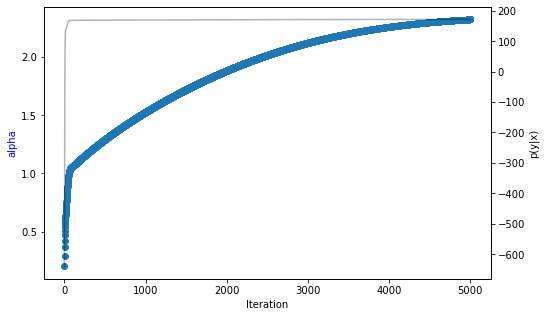

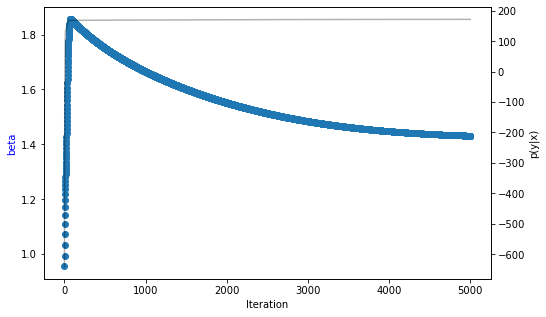

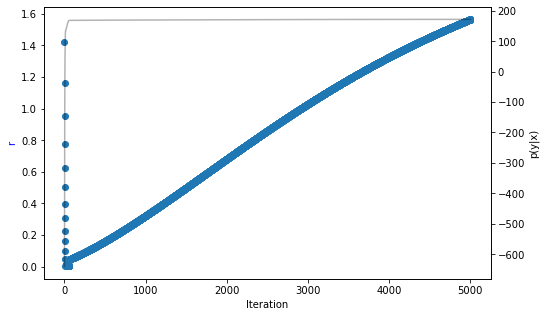

In [60]:
for key in paras_names:
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(np.arange(len(pars[key])), pars[key])
    ax.set_ylabel(key, color='blue')
    ax1 = ax.twinx()
    ax1.plot(np.arange(len(ll)), ll, color='black', alpha=0.3)
    
    ax.set_xlabel("Iteration")
    ax1.set_ylabel(r"p(y|x)")